In [94]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/Reconnect2

# !pwd

In [95]:
# importing required python packages
import datetime
import datetime as dt
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [96]:
# loading and preprocessing the data
def read_file(path):
  ts1 = pd.read_csv(path,parse_dates=[0])

  ts1['Hour']-=1
  for i in range(len(ts1['Hour'])):
    if ts1['Hour'][i] < 10 and ts1['Hour'][i] > -1:
      ts1['Hour'][i]='0'+str(ts1['Hour'][i])+':00:00'
    else:
      ts1['Hour'][i]=str(ts1['Hour'][i])+':00:00'
  ts1['Date'] = [d.date() for d in ts1['Date']]
  ts1['Hour']=pd.to_datetime(ts1['Hour'], format='%H:%M:%S').dt.time

  for i in range(len(ts1['Hour'])):
    ts1['Date'][i]=datetime.datetime.combine(ts1['Date'][i], ts1['Hour'][i])
    ts1['Date'][i]=pd.Timestamp(ts1['Date'][i])

  ts1=ts1.drop(['Hour'], axis = 1) 
  ts = ts1.rename(columns={"Date":"datetime","Load":"observation"}).sort_values(by="datetime")
  return ts

In [97]:
# feb=pd.read_csv('1_Load_History.csv')
# print(feb.head())
# feb=(feb[feb['Date']!='2/29/2008']).reset_index()
# feb=feb.drop(['index'], axis = 1) 
# feb.to_csv('1_Load_History_without_Feb.csv')

In [98]:
ts=read_file('1_Load_History_without_feb.csv')

In [99]:
ts.head()

,datetime,observation
0,2008-01-01 00:00:00,151.1
1,2008-01-01 01:00:00,147.8
2,2008-01-01 02:00:00,145.3
3,2008-01-01 03:00:00,144.1
4,2008-01-01 04:00:00,146.5


In [100]:
start_time = pd.to_datetime('2011-12-01 00:00:00',infer_datetime_format=True)
end_time = pd.to_datetime('2011-12-31 23:00:00', infer_datetime_format=True)

future_datetime=pd.date_range(start_time, end_time, freq='h')
future_observations=[0 for _ in range(len(future_datetime))]

ts_future = pd.DataFrame(list(zip(future_datetime, future_observations)), columns =['datetime', 'observation']) 
ts_overall=pd.concat([ts,ts_future]).reset_index()
ts_overall=ts_overall.drop(['index'], axis = 1) 

print(ts_overall.head())
print(ts_overall.tail())

              datetime  observation
0  2008-01-01 00:00:00        151.1
1  2008-01-01 01:00:00        147.8
2  2008-01-01 02:00:00        145.3
3  2008-01-01 03:00:00        144.1
4  2008-01-01 04:00:00        146.5
                  datetime  observation
35035  2011-12-31 19:00:00          0.0
35036  2011-12-31 20:00:00          0.0
35037  2011-12-31 21:00:00          0.0
35038  2011-12-31 22:00:00          0.0
35039  2011-12-31 23:00:00          0.0


In [101]:
def generate_datetime_features(df: pd.DataFrame, datetime_col: str) -> pd.DataFrame:
    """
    Creates time series features from datetime column.
    :param df: Dataframe containing `datetime_col`
    :param datetime_col: Column name for datetime dtype series.
    :return: Input df with additional time frequency feature columns.
    """
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['date_hour'] = df[datetime_col].dt.floor('H')
    df['date'] = df[datetime_col].dt.floor('D')
    df['hour_of_day'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    df['quarter_of_year'] = df[datetime_col].dt.quarter
    df['month_of_year'] = df[datetime_col].dt.month
    df['year'] = df[datetime_col].dt.year
    df['day_of_year'] = df[datetime_col].dt.dayofyear
    df['day_of_month'] = df[datetime_col].dt.day
    df['week_of_year'] = df[datetime_col].dt.weekofyear
    
    return df

In [102]:
# generating datetime features
dataset_train = generate_datetime_features(ts_overall, "datetime")

dataset_train.head(5)

,datetime,observation,date_hour,date,hour_of_day,day_of_week,quarter_of_year,month_of_year,year,day_of_year,day_of_month,week_of_year
0,2008-01-01 00:00:00,151.1,2008-01-01 00:00:00,2008-01-01,0,1,1,1,2008,1,1,1
1,2008-01-01 01:00:00,147.8,2008-01-01 01:00:00,2008-01-01,1,1,1,1,2008,1,1,1
2,2008-01-01 02:00:00,145.3,2008-01-01 02:00:00,2008-01-01,2,1,1,1,2008,1,1,1
3,2008-01-01 03:00:00,144.1,2008-01-01 03:00:00,2008-01-01,3,1,1,1,2008,1,1,1
4,2008-01-01 04:00:00,146.5,2008-01-01 04:00:00,2008-01-01,4,1,1,1,2008,1,1,1


In [103]:
dataset_train.tail(5)

,datetime,observation,date_hour,date,hour_of_day,day_of_week,quarter_of_year,month_of_year,year,day_of_year,day_of_month,week_of_year
35035,2011-12-31 19:00:00,0.0,2011-12-31 19:00:00,2011-12-31,19,5,4,12,2011,365,31,52
35036,2011-12-31 20:00:00,0.0,2011-12-31 20:00:00,2011-12-31,20,5,4,12,2011,365,31,52
35037,2011-12-31 21:00:00,0.0,2011-12-31 21:00:00,2011-12-31,21,5,4,12,2011,365,31,52
35038,2011-12-31 22:00:00,0.0,2011-12-31 22:00:00,2011-12-31,22,5,4,12,2011,365,31,52
35039,2011-12-31 23:00:00,0.0,2011-12-31 23:00:00,2011-12-31,23,5,4,12,2011,365,31,52


In [152]:
['observation'] +list(dataset_train)[1:12]

['observation',
 'hour_of_day',
 'day_of_week',
 'quarter_of_year',
 'month_of_year',
 'year',
 'day_of_year',
 'day_of_month',
 'week_of_year']

In [154]:
# Select features (columns) to be involved intro training and predictions
#cols = list(dataset_train)[4:12]
cols = ['observation'] +list(dataset_train)[1:12]
# Extract dates (will be used in visualization)
#datelist_train = list(dataset_train['datetime'])
#datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
#print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (35040, 9)
Featured selected: ['observation', 'hour_of_day', 'day_of_week', 'quarter_of_year', 'month_of_year', 'year', 'day_of_year', 'day_of_month', 'week_of_year']


In [155]:
# plotting interactive time series
fig = px.scatter(generate_datetime_features(ts, "datetime"), x="datetime", y="observation", hover_data=["day_of_week"])
fig.update_traces(mode='markers+lines', marker_size=5)
fig.show()

In [156]:
def lineplot_agg_grouped(
    df: pd.DataFrame,
    group_col: str,
    target_col: str,
    y_label: str,
    agg_type: str = "mean",
    x_ticks: int = 0,
) -> None:
    """
    plots the aggregate value of a column in a df grouped by another column
    :param df: pd.DataFrame with columns `group_col` and `target_col`.
    :param group_col: column name in `df` to group by.
    :param target_col: column name in `df` to average over.
    :param y_label: y axis label.
    :param agg_type: aggregate type (e.g. mean, sum, first)
    :param x_ticks: rotation (degree) of x axis ticks.
    :return: None but plot is generated.
    """
    agg_df = df.groupby([group_col]).agg({target_col:agg_type}).reset_index()
    
    plt.figure(figsize=(8,5))
    ax = sns.lineplot(data=agg_df, x=agg_df[group_col], y=target_col, marker="o")   
    ax.set(ylabel=y_label)
    plt.xticks(rotation=x_ticks)

    return

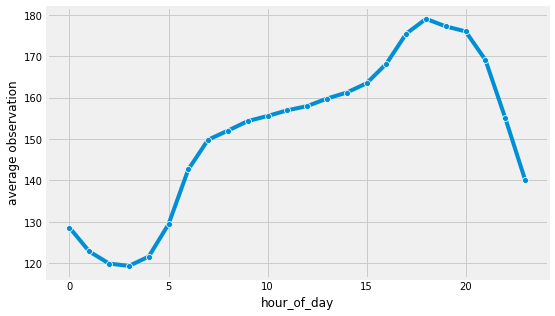

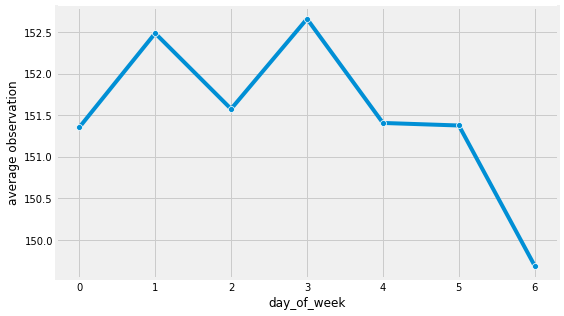

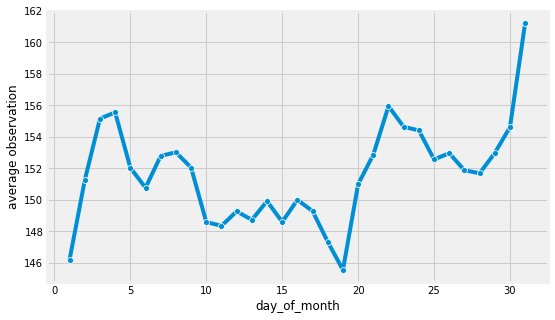

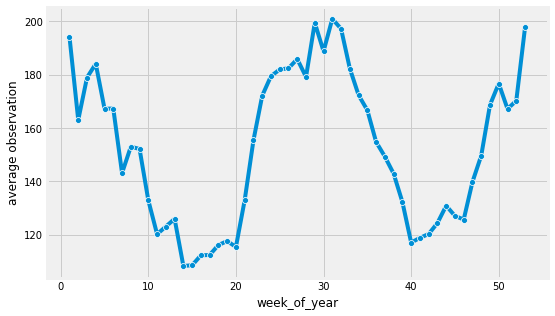

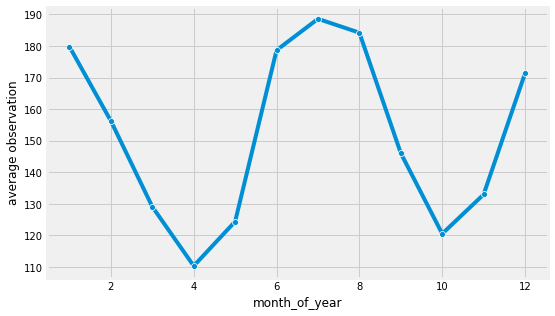

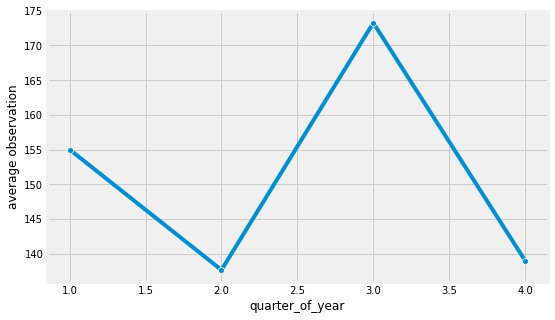

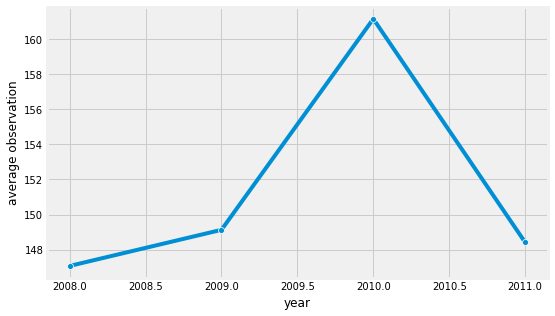

In [157]:
# plotting average observation grouped by different datetime features
ts_features = ['hour_of_day',
               'day_of_week',
               'day_of_month',
               'week_of_year',
               'month_of_year',
               'quarter_of_year',
               'year']
for ts_feature in ts_features:
    lineplot_agg_grouped(
        df = generate_datetime_features(ts, "datetime"),
        group_col = ts_feature,
        target_col = 'observation',
        y_label = 'average observation',
        agg_type = "mean",
        x_ticks = 0
    )

Step #2. Data pre-processing

Removing all commas and convert data to matrix shape format.

In [158]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')


dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy() #as_matrix()

print('Shape of training set == {}.'.format(training_set.shape))
print(training_set)

Shape of training set == (35040, 9).
[[151.1   0.    1.  ...   1.    1.    1. ]
 [147.8   1.    1.  ...   1.    1.    1. ]
 [145.3   2.    1.  ...   1.    1.    1. ]
 ...
 [  0.   21.    5.  ... 365.   31.   52. ]
 [  0.   22.    5.  ... 365.   31.   52. ]
 [  0.   23.    5.  ... 365.   31.   52. ]]


In [159]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
#print(training_set_scaled)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 0.05298791],
       [-0.00923919],
       [-0.05638094],
       ...,
       [-2.79625924],
       [-2.79625924],
       [-2.79625924]])

In [160]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_past = 120     # Number of past items(hours) we want to use to predict the future (5days=5*24=120)
n_future = 8760-n_past+1   # Number of items(hours) we want to predict into the future


for i in range(n_past, len(training_set_scaled),24):
    if i + n_future - 1 <=34272:
      X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
      y_train.append(training_set_scaled[i + n_future - 1:i + n_future+(24-1), 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1064, 120, 8).
y_train shape == (1064, 24).


PART 2. Create a model. Training

Step #3. Building the LSTM based Neural Network

In [161]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [162]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=40, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=24, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

################################

# # Initializing the Neural Network based on LSTM
# model = Sequential()

# # Adding 1st LSTM layer
# model.add(LSTM(units=64, activation="tanh", return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# # Adding 2nd LSTM layer
# model.add(LSTM(units=32,activation="tanh", return_sequences=True))
# # Adding Dropout
# model.add(Dropout(0.25))

# # Adding 3rd LSTM layer
# model.add(LSTM(units=16,activation="tanh", return_sequences=False))
# # Adding Dropout
# model.add(Dropout(0.25))

# # Output layer
# model.add(Dense(units=1, activation='linear'))

# # Compiling the Neural Network
# model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [163]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - 5s 640ms/step - loss: 0.8413 - val_loss: 0.6041

Epoch 00001: val_loss improved from inf to 0.60414, saving model to weights.h5
Epoch 2/30
4/4 [==============================] - 1s 366ms/step - loss: 0.5364 - val_loss: 0.4889

Epoch 00002: val_loss improved from 0.60414 to 0.48887, saving model to weights.h5
Epoch 3/30
4/4 [==============================] - 1s 358ms/step - loss: 0.4755 - val_loss: 0.5120

Epoch 00003: val_loss did not improve from 0.48887
Epoch 4/30
4/4 [==============================] - 1s 359ms/step - loss: 0.4814 - val_loss: 0.7407

Epoch 00004: val_loss did not improve from 0.48887
Epoch 5/30
4/4 [==============================] - 1s 370ms/step - loss: 0.4290 - val_loss: 0.5279

Epoch 00005: val_loss did not improve from 0.48887
Epoch 6/30
4/4 [==============================] - 1s 368ms/step - loss: 0.4016 - val_loss: 0.7828

Epoch 00006: val_loss did not improve from 0.48887
Epoch 7/30
4/4 [========================

perform predictions for the last 744 items, since 2011-12-01 00:00 to 2011-12-31 23:00.

PART 3. Make future predictions

In [164]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_past = 120     # Number of past items(hours) we want to use to predict the future (5days=5*24=120)
n_future = 8760-n_past+1   # Number of items(hours) we want to predict into the future


for i in range(n_past, len(training_set_scaled),24):
    if i + n_future - 1 >=34272+24 and i + n_future - 1 <=35016:
      X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
      #y_train.append(training_set_scaled[i + n_future - 1:i + n_future+(24-1), 0])

X_train= np.array(X_train)

print('X_train shape == {}.'.format(X_train.shape))

X_train shape == (31, 120, 8).


In [165]:
predictions_future = model.predict(X_train)
predictions_future1=sc_predict.inverse_transform(predictions_future)

In [166]:
ts_overall['observation'][35064-744-24:35064-24]=list(predictions_future1.reshape(31*24,1))
# ts_overall['observation']

In [167]:
ts_future = pd.DataFrame(list(zip(future_datetime, ts_overall['observation'][35064-744:35064])), columns =['datetime', 'observation'])
ts_future.to_csv('submissionq1.csv') 

In [168]:
ts_overall.tail()

,datetime,observation,date_hour,date,hour_of_day,day_of_week,quarter_of_year,month_of_year,year,day_of_year,day_of_month,week_of_year
35035,2011-12-31 19:00:00,175.786407,2011-12-31 19:00:00,2011-12-31,19,5,4,12,2011,365,31,52
35036,2011-12-31 20:00:00,177.517227,2011-12-31 20:00:00,2011-12-31,20,5,4,12,2011,365,31,52
35037,2011-12-31 21:00:00,176.444717,2011-12-31 21:00:00,2011-12-31,21,5,4,12,2011,365,31,52
35038,2011-12-31 22:00:00,175.134735,2011-12-31 22:00:00,2011-12-31,22,5,4,12,2011,365,31,52
35039,2011-12-31 23:00:00,161.837372,2011-12-31 23:00:00,2011-12-31,23,5,4,12,2011,365,31,52


/end

In [169]:
# plotting interactive time series
fig = px.scatter(ts_overall, x="datetime", y="observation", hover_data=["day_of_week"])
fig.update_traces(mode='markers+lines', marker_size=5)
fig.show()

In [170]:
def lineplot_agg_grouped(
    df: pd.DataFrame,
    group_col: str,
    target_col: str,
    y_label: str,
    agg_type: str = "mean",
    x_ticks: int = 0,
) -> None:
    """
    plots the aggregate value of a column in a df grouped by another column
    :param df: pd.DataFrame with columns `group_col` and `target_col`.
    :param group_col: column name in `df` to group by.
    :param target_col: column name in `df` to average over.
    :param y_label: y axis label.
    :param agg_type: aggregate type (e.g. mean, sum, first)
    :param x_ticks: rotation (degree) of x axis ticks.
    :return: None but plot is generated.
    """
    agg_df = df.groupby([group_col]).agg({target_col:agg_type}).reset_index()
    
    plt.figure(figsize=(8,5))
    ax = sns.lineplot(data=agg_df, x=agg_df[group_col], y=target_col, marker="o")   
    ax.set(ylabel=y_label)
    plt.xticks(rotation=x_ticks)

    return

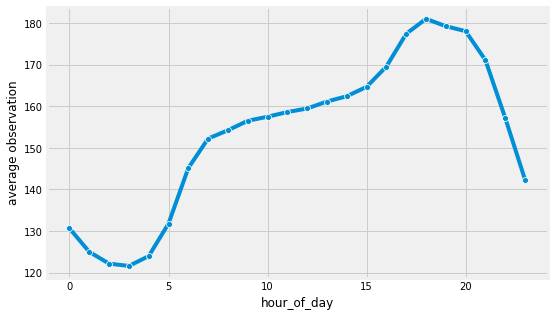

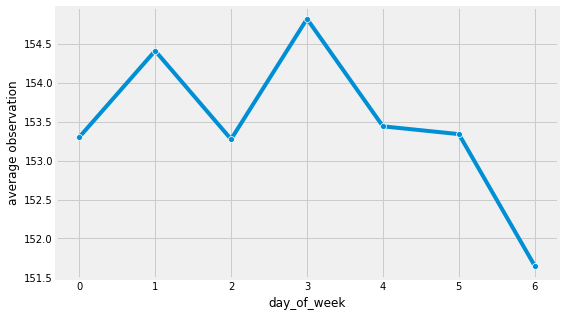

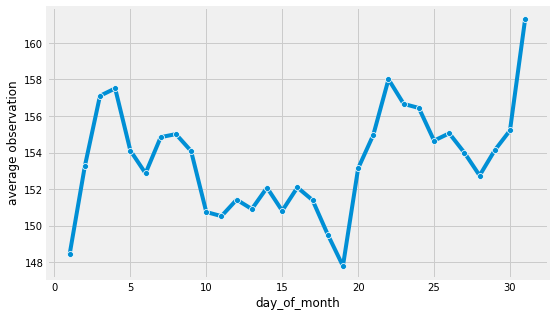

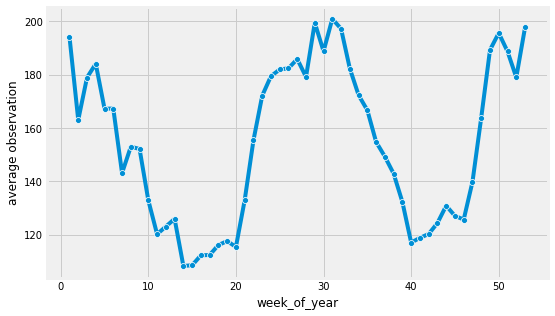

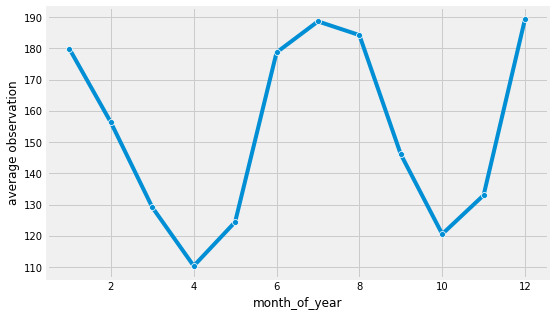

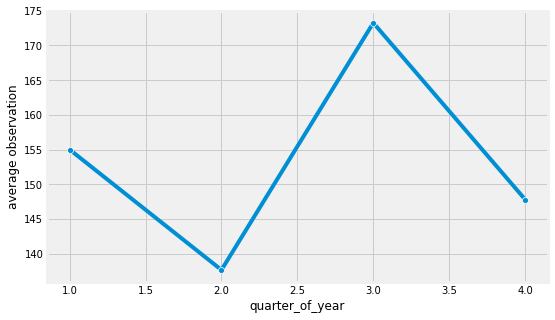

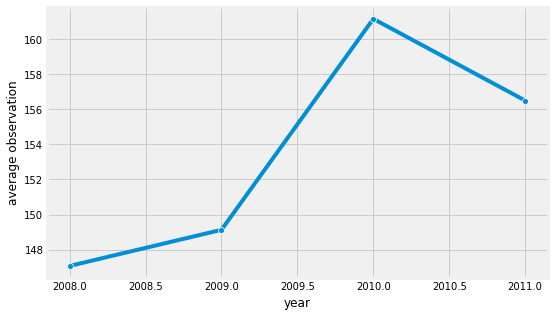

In [171]:
# plotting average observation grouped by different datetime features
ts_features = ['hour_of_day',
               'day_of_week',
               'day_of_month',
               'week_of_year',
               'month_of_year',
               'quarter_of_year',
               'year']
for ts_feature in ts_features:
    lineplot_agg_grouped(
        df = ts_overall,
        group_col = ts_feature,
        target_col = 'observation',
        y_label = 'average observation',
        agg_type = "mean",
        x_ticks = 0
    )